# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

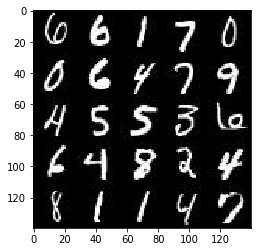

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

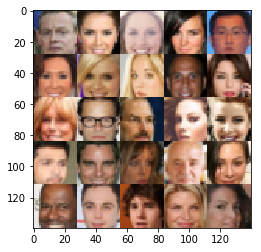

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width,image_height,image_channels), name='inputs_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32)
    return inputs_real, inputs_z, learning_rate
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 832, in start\n    self._run_callback(self._callbacks.popleft())', 'File

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse = reuse):
        # input layer 
        input_layer = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        input_layer_relu = tf.maximum(alpha*input_layer,input_layer)
        
        # hidden  layer 1
        hidden_layer_1 = tf.layers.conv2d(input_layer_relu,128, 5, strides=2, padding='same')
        hidden_layer_1_batch_normalization = tf.layers.batch_normalization(hidden_layer_1,training=True)
        hidden_layer_1_relu = tf.maximum(alpha*hidden_layer_1_batch_normalization,hidden_layer_1_batch_normalization)
        
        # hidden  layer 2
        hidden_layer_2 = tf.layers.conv2d(input_layer_relu, 256, 5, strides=2, padding='same')
        hidden_layer_2_batch_normalization = tf.layers.batch_normalization(hidden_layer_2,training=True)
        hidden_layer_2_relu = tf.maximum(alpha*hidden_layer_2_batch_normalization, hidden_layer_2_batch_normalization)
        # flatten layer 
        flatten = tf.reshape(hidden_layer_2_relu,(-1, 4*4*256))
        
        # Logits and tanh output
        logits = tf.layers.dense(flatten, 1)
        out = tf.tanh(logits)


    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=not is_train):
        alpha = 0.2

        x1 =  tf.layers.dense(z, 2*2*512)
        # reshape
        x1 = tf.reshape(x1,(-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(alpha * x1,x1)
        # reverseing the descriminator settings 
        #
        hidden_layer_2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2,padding='valid')
        hidden_layer_2_batch_normalization = tf.layers.batch_normalization(hidden_layer_2, training=is_train)
        hidden_layer_2_relu = tf.maximum(alpha*hidden_layer_2_batch_normalization, hidden_layer_2_batch_normalization)
        
        
        #
        hidden_layer_1 = tf.layers.conv2d_transpose(hidden_layer_2_relu, 128, 5, strides=2, padding ='same')
        hidden_layer_1_batch_normalization = tf.layers.batch_normalization(hidden_layer_1, training = is_train)
        hidden_layer_1_relu = tf.maximum(alpha*hidden_layer_1_batch_normalization, hidden_layer_1_batch_normalization)
        
        #@link :conv2d_transpose : <https://www.tensorflow.org/api_docs/python/tf/layers/conv2d_transpose>
        logits = tf.layers.conv2d_transpose(hidden_layer_1_relu, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    generator_model = generator(input_z,out_channel_dim)
    discriminator_model_real,discriminator_model_real_logits = discriminator(input_real)
    discriminator_model_fake,discriminator_model_fake_logits = discriminator(generator_model,reuse=True)
    
    discriminator_model_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_model_real_logits,labels=tf.ones_like(discriminator_model_real)))
    discriminator_model_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_model_fake_logits,labels=tf.zeros_like(discriminator_model_fake)))
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_model_fake_logits,labels=tf.ones_like(discriminator_model_fake)))

    discriminator_loss = discriminator_model_real_loss+discriminator_model_fake_loss
    
    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Optimizers

    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    _,image_width, image_height,image_channels= data_shape
    # generate the model_input
    inputs_real, inputs_z, lr = model_inputs(image_width, image_height,image_channels,z_dim)
    
    #generate the model loss 
    discriminator_loss, generator_loss = model_loss(inputs_real, inputs_z,image_channels)
    
    #generate mode_opt
    d_train_opt, g_train_opt = model_opt(discriminator_loss,generator_loss,learning_rate,beta1)
    
    steps= 0
    losses = []
    n_images = 25
    print_every = 10
    show_every = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2.0
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                 # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z,lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z,lr:learning_rate})
                
                if steps % print_every ==0:
                    train_loss_d = discriminator_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = generator_loss.eval({inputs_z: batch_z})
            
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess,n_images,inputs_z,image_channels,data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/10... Discriminator Loss: 0.9313... Generator Loss: 1.1560
Epoch 1/10... Discriminator Loss: 1.1971... Generator Loss: 1.0307
Epoch 1/10... Discriminator Loss: 1.5847... Generator Loss: 0.7640
Epoch 1/10... Discriminator Loss: 0.8714... Generator Loss: 1.0043
Epoch 1/10... Discriminator Loss: 0.8458... Generator Loss: 1.0097
Epoch 1/10... Discriminator Loss: 1.1060... Generator Loss: 0.9380
Epoch 1/10... Discriminator Loss: 1.0902... Generator Loss: 0.9009
Epoch 1/10... Discriminator Loss: 0.9391... Generator Loss: 0.9808
Epoch 1/10... Discriminator Loss: 1.1613... Generator Loss: 0.9558
Epoch 1/10... Discriminator Loss: 1.0809... Generator Loss: 0.9022


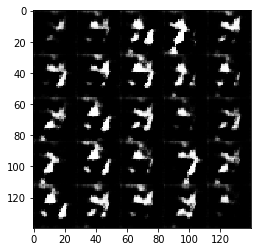

Epoch 1/10... Discriminator Loss: 0.9095... Generator Loss: 0.9640
Epoch 1/10... Discriminator Loss: 1.1262... Generator Loss: 1.2341
Epoch 1/10... Discriminator Loss: 1.0755... Generator Loss: 0.9668
Epoch 1/10... Discriminator Loss: 1.0309... Generator Loss: 1.0760
Epoch 1/10... Discriminator Loss: 1.0978... Generator Loss: 0.6671
Epoch 1/10... Discriminator Loss: 1.5244... Generator Loss: 1.8630
Epoch 1/10... Discriminator Loss: 1.2603... Generator Loss: 1.2216
Epoch 1/10... Discriminator Loss: 1.0611... Generator Loss: 0.9455
Epoch 1/10... Discriminator Loss: 1.0896... Generator Loss: 0.9455
Epoch 1/10... Discriminator Loss: 1.0539... Generator Loss: 1.1720


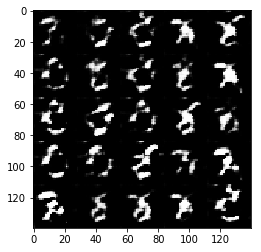

Epoch 1/10... Discriminator Loss: 0.9083... Generator Loss: 1.2435
Epoch 1/10... Discriminator Loss: 0.9798... Generator Loss: 1.5037
Epoch 1/10... Discriminator Loss: 0.9965... Generator Loss: 1.4478
Epoch 1/10... Discriminator Loss: 0.9310... Generator Loss: 1.1995
Epoch 1/10... Discriminator Loss: 1.3290... Generator Loss: 1.4003
Epoch 1/10... Discriminator Loss: 1.0260... Generator Loss: 0.9553
Epoch 1/10... Discriminator Loss: 0.9018... Generator Loss: 1.3137
Epoch 1/10... Discriminator Loss: 0.9838... Generator Loss: 1.0816
Epoch 1/10... Discriminator Loss: 1.0951... Generator Loss: 0.7177
Epoch 1/10... Discriminator Loss: 1.1854... Generator Loss: 0.6584


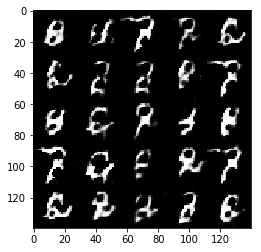

Epoch 1/10... Discriminator Loss: 1.1086... Generator Loss: 1.1928
Epoch 1/10... Discriminator Loss: 1.0918... Generator Loss: 1.2587
Epoch 1/10... Discriminator Loss: 1.0446... Generator Loss: 1.1353
Epoch 1/10... Discriminator Loss: 1.1325... Generator Loss: 0.7607
Epoch 1/10... Discriminator Loss: 1.1841... Generator Loss: 0.9726
Epoch 1/10... Discriminator Loss: 1.2378... Generator Loss: 0.7612
Epoch 1/10... Discriminator Loss: 1.1954... Generator Loss: 1.0122
Epoch 1/10... Discriminator Loss: 1.1414... Generator Loss: 0.9239
Epoch 1/10... Discriminator Loss: 1.2350... Generator Loss: 0.8572
Epoch 1/10... Discriminator Loss: 1.0910... Generator Loss: 0.9739


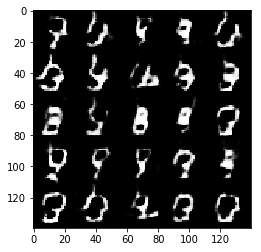

Epoch 1/10... Discriminator Loss: 1.1426... Generator Loss: 0.9197
Epoch 1/10... Discriminator Loss: 1.0872... Generator Loss: 1.0213
Epoch 1/10... Discriminator Loss: 1.2004... Generator Loss: 1.1273
Epoch 1/10... Discriminator Loss: 1.1472... Generator Loss: 1.1313
Epoch 1/10... Discriminator Loss: 1.1838... Generator Loss: 0.8075
Epoch 1/10... Discriminator Loss: 1.1564... Generator Loss: 0.7526
Epoch 2/10... Discriminator Loss: 1.2036... Generator Loss: 0.9040
Epoch 2/10... Discriminator Loss: 2.0891... Generator Loss: 1.8571
Epoch 2/10... Discriminator Loss: 1.2402... Generator Loss: 0.8565
Epoch 2/10... Discriminator Loss: 1.2011... Generator Loss: 0.7956


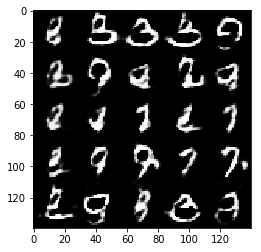

Epoch 2/10... Discriminator Loss: 1.2146... Generator Loss: 0.9554
Epoch 2/10... Discriminator Loss: 1.1625... Generator Loss: 0.8960
Epoch 2/10... Discriminator Loss: 1.1666... Generator Loss: 0.9091
Epoch 2/10... Discriminator Loss: 1.1615... Generator Loss: 0.9137
Epoch 2/10... Discriminator Loss: 1.1629... Generator Loss: 0.7893
Epoch 2/10... Discriminator Loss: 1.1774... Generator Loss: 0.7908
Epoch 2/10... Discriminator Loss: 1.2065... Generator Loss: 0.8903
Epoch 2/10... Discriminator Loss: 1.2004... Generator Loss: 0.7589
Epoch 2/10... Discriminator Loss: 1.2954... Generator Loss: 0.5472
Epoch 2/10... Discriminator Loss: 1.2041... Generator Loss: 0.7634


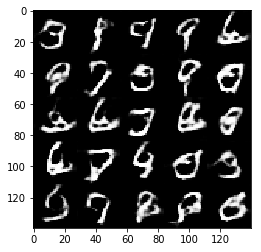

Epoch 2/10... Discriminator Loss: 1.3044... Generator Loss: 0.6014
Epoch 2/10... Discriminator Loss: 1.2160... Generator Loss: 0.9102
Epoch 2/10... Discriminator Loss: 1.2305... Generator Loss: 0.7101
Epoch 2/10... Discriminator Loss: 1.2455... Generator Loss: 0.6132
Epoch 2/10... Discriminator Loss: 1.1662... Generator Loss: 0.7577
Epoch 2/10... Discriminator Loss: 1.1424... Generator Loss: 0.9726
Epoch 2/10... Discriminator Loss: 1.7534... Generator Loss: 1.6504
Epoch 2/10... Discriminator Loss: 1.2311... Generator Loss: 1.0118
Epoch 2/10... Discriminator Loss: 1.2230... Generator Loss: 1.1283
Epoch 2/10... Discriminator Loss: 1.1814... Generator Loss: 0.8169


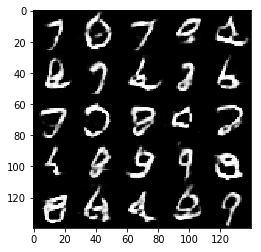

Epoch 2/10... Discriminator Loss: 1.1594... Generator Loss: 0.7369
Epoch 2/10... Discriminator Loss: 1.1811... Generator Loss: 0.7278
Epoch 2/10... Discriminator Loss: 1.1732... Generator Loss: 0.9684
Epoch 2/10... Discriminator Loss: 1.2529... Generator Loss: 1.0280
Epoch 2/10... Discriminator Loss: 1.2694... Generator Loss: 0.9959
Epoch 2/10... Discriminator Loss: 1.2184... Generator Loss: 0.9239
Epoch 2/10... Discriminator Loss: 1.1931... Generator Loss: 0.7033
Epoch 2/10... Discriminator Loss: 1.2111... Generator Loss: 0.8862
Epoch 2/10... Discriminator Loss: 1.3077... Generator Loss: 0.6326
Epoch 2/10... Discriminator Loss: 1.2212... Generator Loss: 0.7595


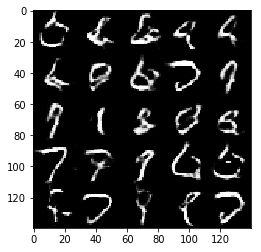

Epoch 2/10... Discriminator Loss: 1.2764... Generator Loss: 0.7717
Epoch 2/10... Discriminator Loss: 1.1852... Generator Loss: 0.8890
Epoch 2/10... Discriminator Loss: 1.2507... Generator Loss: 0.6192
Epoch 2/10... Discriminator Loss: 1.2270... Generator Loss: 0.8906
Epoch 2/10... Discriminator Loss: 1.2187... Generator Loss: 0.7465
Epoch 2/10... Discriminator Loss: 1.1937... Generator Loss: 0.7971
Epoch 2/10... Discriminator Loss: 1.1759... Generator Loss: 0.8851
Epoch 2/10... Discriminator Loss: 1.3172... Generator Loss: 1.0829
Epoch 2/10... Discriminator Loss: 1.6440... Generator Loss: 1.2820
Epoch 2/10... Discriminator Loss: 1.3256... Generator Loss: 0.9203


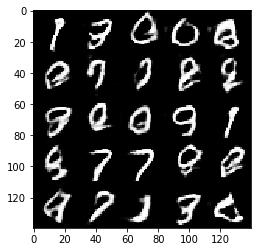

Epoch 2/10... Discriminator Loss: 1.2021... Generator Loss: 0.9120
Epoch 2/10... Discriminator Loss: 1.2354... Generator Loss: 0.7099
Epoch 2/10... Discriminator Loss: 1.1836... Generator Loss: 0.8255
Epoch 3/10... Discriminator Loss: 1.1955... Generator Loss: 0.8100
Epoch 3/10... Discriminator Loss: 1.1859... Generator Loss: 0.8634
Epoch 3/10... Discriminator Loss: 1.1872... Generator Loss: 0.6858
Epoch 3/10... Discriminator Loss: 1.2088... Generator Loss: 0.6973
Epoch 3/10... Discriminator Loss: 1.2247... Generator Loss: 1.0679
Epoch 3/10... Discriminator Loss: 1.1599... Generator Loss: 0.8682
Epoch 3/10... Discriminator Loss: 1.2904... Generator Loss: 0.8662


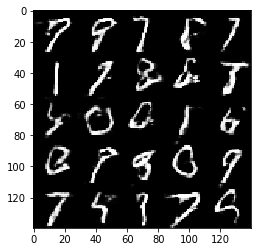

Epoch 3/10... Discriminator Loss: 1.3074... Generator Loss: 0.6329
Epoch 3/10... Discriminator Loss: 1.1792... Generator Loss: 0.8388
Epoch 3/10... Discriminator Loss: 1.1758... Generator Loss: 0.9192
Epoch 3/10... Discriminator Loss: 1.3086... Generator Loss: 1.2064
Epoch 3/10... Discriminator Loss: 1.1961... Generator Loss: 1.0801
Epoch 3/10... Discriminator Loss: 1.2744... Generator Loss: 0.6009
Epoch 3/10... Discriminator Loss: 1.2303... Generator Loss: 0.7634
Epoch 3/10... Discriminator Loss: 1.2454... Generator Loss: 0.9994
Epoch 3/10... Discriminator Loss: 1.3843... Generator Loss: 1.0181
Epoch 3/10... Discriminator Loss: 1.3289... Generator Loss: 0.7541


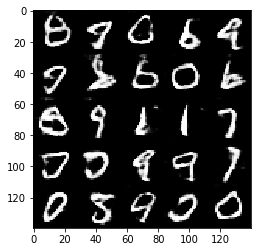

Epoch 3/10... Discriminator Loss: 1.2397... Generator Loss: 0.7733
Epoch 3/10... Discriminator Loss: 1.2252... Generator Loss: 0.7011
Epoch 3/10... Discriminator Loss: 1.2120... Generator Loss: 0.7909
Epoch 3/10... Discriminator Loss: 1.1802... Generator Loss: 0.9341
Epoch 3/10... Discriminator Loss: 1.2074... Generator Loss: 1.0077
Epoch 3/10... Discriminator Loss: 1.2557... Generator Loss: 1.0466
Epoch 3/10... Discriminator Loss: 1.1843... Generator Loss: 0.8856
Epoch 3/10... Discriminator Loss: 1.1992... Generator Loss: 0.8717
Epoch 3/10... Discriminator Loss: 1.6667... Generator Loss: 1.3532
Epoch 3/10... Discriminator Loss: 1.7755... Generator Loss: 1.6617


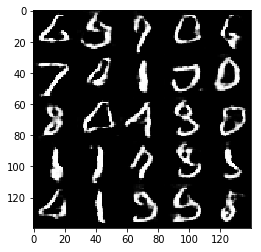

Epoch 3/10... Discriminator Loss: 1.2204... Generator Loss: 0.8872
Epoch 3/10... Discriminator Loss: 1.1838... Generator Loss: 0.8329
Epoch 3/10... Discriminator Loss: 1.1825... Generator Loss: 0.9515
Epoch 3/10... Discriminator Loss: 1.1857... Generator Loss: 0.8027
Epoch 3/10... Discriminator Loss: 1.2213... Generator Loss: 1.1003
Epoch 3/10... Discriminator Loss: 1.1549... Generator Loss: 0.7910
Epoch 3/10... Discriminator Loss: 1.1814... Generator Loss: 0.8472
Epoch 3/10... Discriminator Loss: 1.2449... Generator Loss: 1.0630
Epoch 3/10... Discriminator Loss: 1.1975... Generator Loss: 0.8309
Epoch 3/10... Discriminator Loss: 1.1809... Generator Loss: 0.6950


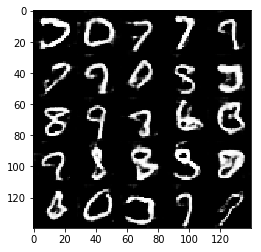

Epoch 3/10... Discriminator Loss: 1.1723... Generator Loss: 0.8765
Epoch 3/10... Discriminator Loss: 1.2807... Generator Loss: 1.1790
Epoch 3/10... Discriminator Loss: 1.2320... Generator Loss: 1.0269
Epoch 3/10... Discriminator Loss: 1.2015... Generator Loss: 1.0145
Epoch 3/10... Discriminator Loss: 1.2162... Generator Loss: 0.9053
Epoch 3/10... Discriminator Loss: 1.2577... Generator Loss: 1.1615
Epoch 3/10... Discriminator Loss: 1.2578... Generator Loss: 0.6453
Epoch 3/10... Discriminator Loss: 1.2410... Generator Loss: 0.6327
Epoch 3/10... Discriminator Loss: 1.2181... Generator Loss: 0.8184
Epoch 3/10... Discriminator Loss: 1.2001... Generator Loss: 0.7871


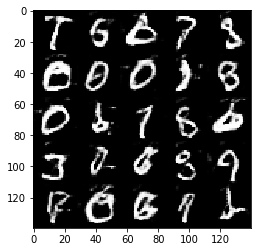

Epoch 4/10... Discriminator Loss: 1.2203... Generator Loss: 0.7775
Epoch 4/10... Discriminator Loss: 1.1853... Generator Loss: 0.8054
Epoch 4/10... Discriminator Loss: 1.2687... Generator Loss: 0.6189
Epoch 4/10... Discriminator Loss: 1.2292... Generator Loss: 1.0667
Epoch 4/10... Discriminator Loss: 1.2807... Generator Loss: 1.0009
Epoch 4/10... Discriminator Loss: 2.2888... Generator Loss: 1.7498
Epoch 4/10... Discriminator Loss: 1.3383... Generator Loss: 0.5856
Epoch 4/10... Discriminator Loss: 1.2507... Generator Loss: 0.9529
Epoch 4/10... Discriminator Loss: 1.2218... Generator Loss: 0.7559
Epoch 4/10... Discriminator Loss: 1.3245... Generator Loss: 1.1912


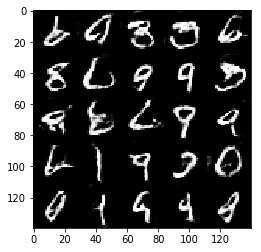

Epoch 4/10... Discriminator Loss: 1.2144... Generator Loss: 0.7265
Epoch 4/10... Discriminator Loss: 1.1782... Generator Loss: 0.8327
Epoch 4/10... Discriminator Loss: 1.2467... Generator Loss: 0.6788
Epoch 4/10... Discriminator Loss: 1.2186... Generator Loss: 0.8783
Epoch 4/10... Discriminator Loss: 1.2414... Generator Loss: 0.5953
Epoch 4/10... Discriminator Loss: 1.1813... Generator Loss: 0.7670
Epoch 4/10... Discriminator Loss: 1.2012... Generator Loss: 0.9474
Epoch 4/10... Discriminator Loss: 1.1727... Generator Loss: 0.8704
Epoch 4/10... Discriminator Loss: 1.2273... Generator Loss: 1.1146
Epoch 4/10... Discriminator Loss: 1.1927... Generator Loss: 0.8397


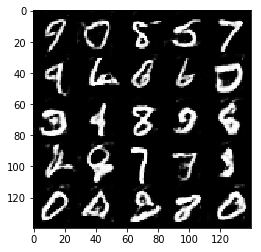

Epoch 4/10... Discriminator Loss: 1.2404... Generator Loss: 0.9343
Epoch 4/10... Discriminator Loss: 1.2413... Generator Loss: 0.9257
Epoch 4/10... Discriminator Loss: 1.2014... Generator Loss: 0.8419
Epoch 4/10... Discriminator Loss: 1.2089... Generator Loss: 0.8093
Epoch 4/10... Discriminator Loss: 1.1734... Generator Loss: 0.7926
Epoch 4/10... Discriminator Loss: 1.1970... Generator Loss: 0.7700
Epoch 4/10... Discriminator Loss: 1.2205... Generator Loss: 0.7004
Epoch 4/10... Discriminator Loss: 1.2066... Generator Loss: 0.8873
Epoch 4/10... Discriminator Loss: 1.1748... Generator Loss: 0.9295
Epoch 4/10... Discriminator Loss: 1.2636... Generator Loss: 1.0518


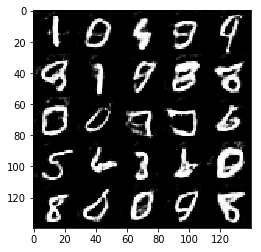

Epoch 4/10... Discriminator Loss: 1.2162... Generator Loss: 0.7149
Epoch 4/10... Discriminator Loss: 1.2806... Generator Loss: 0.9473
Epoch 4/10... Discriminator Loss: 1.2360... Generator Loss: 0.9443
Epoch 4/10... Discriminator Loss: 1.2010... Generator Loss: 0.8400
Epoch 4/10... Discriminator Loss: 1.2081... Generator Loss: 0.9144
Epoch 4/10... Discriminator Loss: 1.2103... Generator Loss: 0.7449
Epoch 4/10... Discriminator Loss: 1.2354... Generator Loss: 0.6617
Epoch 4/10... Discriminator Loss: 1.2358... Generator Loss: 0.7964
Epoch 4/10... Discriminator Loss: 1.2442... Generator Loss: 0.6496
Epoch 4/10... Discriminator Loss: 1.2848... Generator Loss: 0.7565


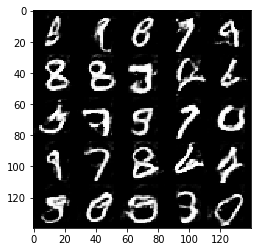

Epoch 4/10... Discriminator Loss: 1.2041... Generator Loss: 0.8246
Epoch 4/10... Discriminator Loss: 1.3351... Generator Loss: 0.7486
Epoch 4/10... Discriminator Loss: 1.2589... Generator Loss: 0.6888
Epoch 4/10... Discriminator Loss: 1.2148... Generator Loss: 0.7675
Epoch 4/10... Discriminator Loss: 1.2205... Generator Loss: 0.7475
Epoch 4/10... Discriminator Loss: 1.2899... Generator Loss: 1.0916
Epoch 4/10... Discriminator Loss: 1.3827... Generator Loss: 1.0772
Epoch 5/10... Discriminator Loss: 1.2259... Generator Loss: 0.9457
Epoch 5/10... Discriminator Loss: 1.2026... Generator Loss: 0.8364
Epoch 5/10... Discriminator Loss: 1.2187... Generator Loss: 0.9270


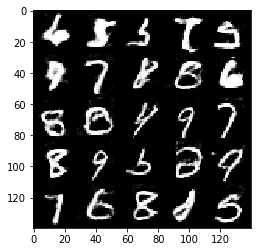

Epoch 5/10... Discriminator Loss: 1.1852... Generator Loss: 0.9294
Epoch 5/10... Discriminator Loss: 1.2284... Generator Loss: 0.9624
Epoch 5/10... Discriminator Loss: 1.2105... Generator Loss: 0.7647
Epoch 5/10... Discriminator Loss: 1.2311... Generator Loss: 0.8863
Epoch 5/10... Discriminator Loss: 1.2393... Generator Loss: 0.8821
Epoch 5/10... Discriminator Loss: 1.3099... Generator Loss: 0.5703
Epoch 5/10... Discriminator Loss: 1.2875... Generator Loss: 0.5762
Epoch 5/10... Discriminator Loss: 1.3404... Generator Loss: 0.7491
Epoch 5/10... Discriminator Loss: 1.2418... Generator Loss: 0.9633
Epoch 5/10... Discriminator Loss: 1.2261... Generator Loss: 0.8725


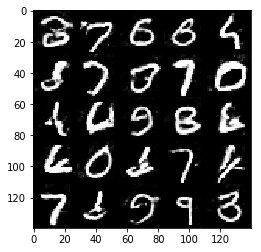

Epoch 5/10... Discriminator Loss: 1.1871... Generator Loss: 0.8633
Epoch 5/10... Discriminator Loss: 1.2331... Generator Loss: 0.7671
Epoch 5/10... Discriminator Loss: 1.2833... Generator Loss: 0.9482
Epoch 5/10... Discriminator Loss: 1.2755... Generator Loss: 1.1180
Epoch 5/10... Discriminator Loss: 1.2488... Generator Loss: 0.7054
Epoch 5/10... Discriminator Loss: 1.2962... Generator Loss: 0.9680
Epoch 5/10... Discriminator Loss: 1.1853... Generator Loss: 0.8899
Epoch 5/10... Discriminator Loss: 1.2050... Generator Loss: 1.0428
Epoch 5/10... Discriminator Loss: 1.2596... Generator Loss: 1.0003
Epoch 5/10... Discriminator Loss: 1.2880... Generator Loss: 0.8451


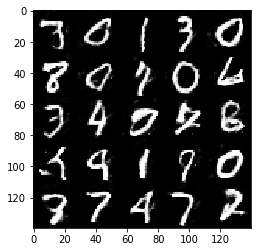

Epoch 5/10... Discriminator Loss: 1.3258... Generator Loss: 0.9423
Epoch 5/10... Discriminator Loss: 1.2678... Generator Loss: 0.7498
Epoch 5/10... Discriminator Loss: 1.2430... Generator Loss: 0.6861
Epoch 5/10... Discriminator Loss: 1.3628... Generator Loss: 0.5411
Epoch 5/10... Discriminator Loss: 1.2195... Generator Loss: 0.8990
Epoch 5/10... Discriminator Loss: 1.1738... Generator Loss: 0.7809
Epoch 5/10... Discriminator Loss: 1.1920... Generator Loss: 0.8580
Epoch 5/10... Discriminator Loss: 1.2084... Generator Loss: 0.8497
Epoch 5/10... Discriminator Loss: 1.2377... Generator Loss: 0.7163
Epoch 5/10... Discriminator Loss: 1.3494... Generator Loss: 0.6481


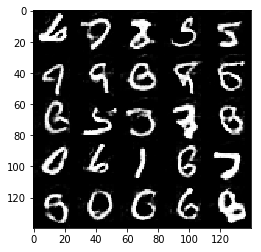

Epoch 5/10... Discriminator Loss: 1.1844... Generator Loss: 0.8101
Epoch 5/10... Discriminator Loss: 1.2326... Generator Loss: 0.7119
Epoch 5/10... Discriminator Loss: 1.2239... Generator Loss: 0.7579
Epoch 5/10... Discriminator Loss: 1.2481... Generator Loss: 0.7958
Epoch 5/10... Discriminator Loss: 1.2891... Generator Loss: 0.7811
Epoch 5/10... Discriminator Loss: 1.7709... Generator Loss: 0.8981
Epoch 5/10... Discriminator Loss: 2.4986... Generator Loss: 1.6759
Epoch 5/10... Discriminator Loss: 1.8343... Generator Loss: 0.7341
Epoch 5/10... Discriminator Loss: 1.3381... Generator Loss: 0.6187
Epoch 5/10... Discriminator Loss: 1.2381... Generator Loss: 0.7599


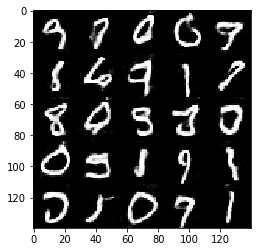

Epoch 5/10... Discriminator Loss: 1.2300... Generator Loss: 0.8020
Epoch 5/10... Discriminator Loss: 1.1994... Generator Loss: 0.7560
Epoch 5/10... Discriminator Loss: 1.2009... Generator Loss: 0.7808
Epoch 5/10... Discriminator Loss: 1.2241... Generator Loss: 0.8108
Epoch 6/10... Discriminator Loss: 1.2356... Generator Loss: 0.8836
Epoch 6/10... Discriminator Loss: 1.2039... Generator Loss: 0.9025
Epoch 6/10... Discriminator Loss: 1.2216... Generator Loss: 0.7806
Epoch 6/10... Discriminator Loss: 1.1941... Generator Loss: 0.8379
Epoch 6/10... Discriminator Loss: 1.2012... Generator Loss: 0.8175
Epoch 6/10... Discriminator Loss: 1.2120... Generator Loss: 0.7978


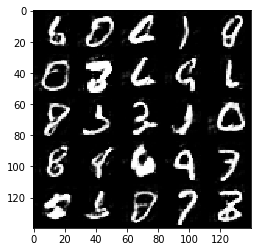

Epoch 6/10... Discriminator Loss: 1.2884... Generator Loss: 0.6335
Epoch 6/10... Discriminator Loss: 1.1739... Generator Loss: 0.7850
Epoch 6/10... Discriminator Loss: 1.2539... Generator Loss: 0.7628
Epoch 6/10... Discriminator Loss: 1.2424... Generator Loss: 0.6576
Epoch 6/10... Discriminator Loss: 1.2252... Generator Loss: 0.7855
Epoch 6/10... Discriminator Loss: 1.2526... Generator Loss: 0.7863
Epoch 6/10... Discriminator Loss: 1.2416... Generator Loss: 0.8362
Epoch 6/10... Discriminator Loss: 1.2102... Generator Loss: 0.9378
Epoch 6/10... Discriminator Loss: 1.2693... Generator Loss: 0.6614
Epoch 6/10... Discriminator Loss: 1.1880... Generator Loss: 0.7074


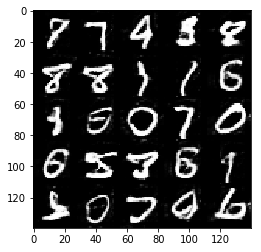

Epoch 6/10... Discriminator Loss: 1.1866... Generator Loss: 0.8132
Epoch 6/10... Discriminator Loss: 1.2008... Generator Loss: 0.9445
Epoch 6/10... Discriminator Loss: 1.2439... Generator Loss: 0.7366
Epoch 6/10... Discriminator Loss: 1.2722... Generator Loss: 0.6927
Epoch 6/10... Discriminator Loss: 1.2535... Generator Loss: 0.7201
Epoch 6/10... Discriminator Loss: 1.2806... Generator Loss: 0.9466
Epoch 6/10... Discriminator Loss: 1.3723... Generator Loss: 0.9714
Epoch 6/10... Discriminator Loss: 1.1926... Generator Loss: 0.7680
Epoch 6/10... Discriminator Loss: 1.2138... Generator Loss: 0.7734
Epoch 6/10... Discriminator Loss: 1.2128... Generator Loss: 0.8052


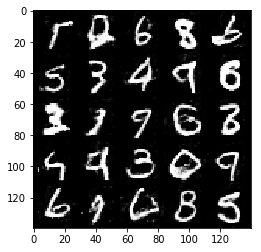

Epoch 6/10... Discriminator Loss: 1.2283... Generator Loss: 0.7527
Epoch 6/10... Discriminator Loss: 1.1827... Generator Loss: 0.7986
Epoch 6/10... Discriminator Loss: 1.2376... Generator Loss: 0.9215
Epoch 6/10... Discriminator Loss: 1.3548... Generator Loss: 1.1667
Epoch 6/10... Discriminator Loss: 1.2394... Generator Loss: 0.8494
Epoch 6/10... Discriminator Loss: 1.1628... Generator Loss: 0.8063
Epoch 6/10... Discriminator Loss: 1.2133... Generator Loss: 0.6958
Epoch 6/10... Discriminator Loss: 1.2802... Generator Loss: 0.7970
Epoch 6/10... Discriminator Loss: 1.2319... Generator Loss: 0.7073
Epoch 6/10... Discriminator Loss: 1.2444... Generator Loss: 0.7721


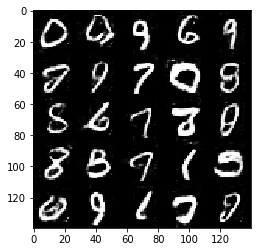

Epoch 6/10... Discriminator Loss: 1.3578... Generator Loss: 0.5028
Epoch 6/10... Discriminator Loss: 1.2694... Generator Loss: 0.7547
Epoch 6/10... Discriminator Loss: 1.2160... Generator Loss: 0.7495
Epoch 6/10... Discriminator Loss: 1.2733... Generator Loss: 0.6517
Epoch 6/10... Discriminator Loss: 1.1903... Generator Loss: 0.9739
Epoch 6/10... Discriminator Loss: 1.2497... Generator Loss: 0.7277
Epoch 6/10... Discriminator Loss: 1.2601... Generator Loss: 0.6498
Epoch 6/10... Discriminator Loss: 1.2984... Generator Loss: 0.6860
Epoch 6/10... Discriminator Loss: 1.2225... Generator Loss: 0.7273
Epoch 6/10... Discriminator Loss: 1.2439... Generator Loss: 0.7378


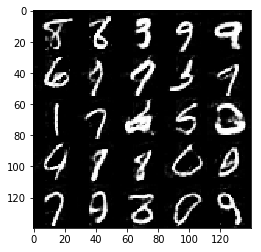

Epoch 7/10... Discriminator Loss: 1.2786... Generator Loss: 0.6661
Epoch 7/10... Discriminator Loss: 1.2449... Generator Loss: 0.7664
Epoch 7/10... Discriminator Loss: 1.2170... Generator Loss: 0.9107
Epoch 7/10... Discriminator Loss: 1.2087... Generator Loss: 0.8889
Epoch 7/10... Discriminator Loss: 1.3018... Generator Loss: 1.1407
Epoch 7/10... Discriminator Loss: 1.1932... Generator Loss: 0.8650
Epoch 7/10... Discriminator Loss: 1.2972... Generator Loss: 0.8626
Epoch 7/10... Discriminator Loss: 1.2200... Generator Loss: 0.8619
Epoch 7/10... Discriminator Loss: 1.2078... Generator Loss: 0.9464
Epoch 7/10... Discriminator Loss: 1.1793... Generator Loss: 0.8152


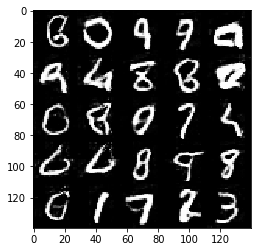

Epoch 7/10... Discriminator Loss: 1.2364... Generator Loss: 0.7987
Epoch 7/10... Discriminator Loss: 1.3332... Generator Loss: 0.5147
Epoch 7/10... Discriminator Loss: 3.4111... Generator Loss: 1.3077
Epoch 7/10... Discriminator Loss: 1.3792... Generator Loss: 0.9237
Epoch 7/10... Discriminator Loss: 1.5461... Generator Loss: 1.1409
Epoch 7/10... Discriminator Loss: 1.3643... Generator Loss: 0.9806
Epoch 7/10... Discriminator Loss: 1.2950... Generator Loss: 0.8021
Epoch 7/10... Discriminator Loss: 1.2312... Generator Loss: 0.7207
Epoch 7/10... Discriminator Loss: 1.2455... Generator Loss: 0.8332
Epoch 7/10... Discriminator Loss: 1.2348... Generator Loss: 0.7571


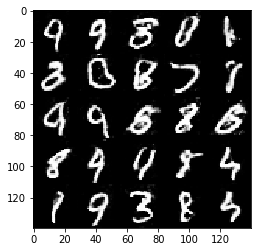

Epoch 7/10... Discriminator Loss: 1.2133... Generator Loss: 0.7651
Epoch 7/10... Discriminator Loss: 1.2484... Generator Loss: 0.8741
Epoch 7/10... Discriminator Loss: 1.1744... Generator Loss: 0.8851
Epoch 7/10... Discriminator Loss: 1.1950... Generator Loss: 0.7489
Epoch 7/10... Discriminator Loss: 1.1926... Generator Loss: 0.7212
Epoch 7/10... Discriminator Loss: 1.1822... Generator Loss: 0.7803
Epoch 7/10... Discriminator Loss: 1.1952... Generator Loss: 0.7729
Epoch 7/10... Discriminator Loss: 1.1933... Generator Loss: 0.8742
Epoch 7/10... Discriminator Loss: 1.1743... Generator Loss: 0.8111
Epoch 7/10... Discriminator Loss: 1.2260... Generator Loss: 0.9751


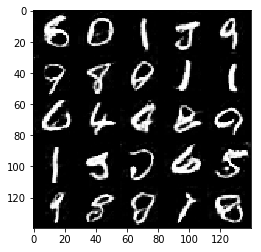

Epoch 7/10... Discriminator Loss: 1.2450... Generator Loss: 0.9893
Epoch 7/10... Discriminator Loss: 1.2041... Generator Loss: 0.8943
Epoch 7/10... Discriminator Loss: 1.2212... Generator Loss: 0.7423
Epoch 7/10... Discriminator Loss: 1.1977... Generator Loss: 0.8897
Epoch 7/10... Discriminator Loss: 1.2342... Generator Loss: 0.7662
Epoch 7/10... Discriminator Loss: 1.2105... Generator Loss: 0.8110
Epoch 7/10... Discriminator Loss: 1.1801... Generator Loss: 0.8784
Epoch 7/10... Discriminator Loss: 1.1937... Generator Loss: 0.8089
Epoch 7/10... Discriminator Loss: 1.2230... Generator Loss: 0.7703
Epoch 7/10... Discriminator Loss: 1.2167... Generator Loss: 0.9522


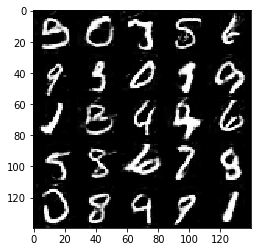

Epoch 7/10... Discriminator Loss: 1.3327... Generator Loss: 0.5682
Epoch 7/10... Discriminator Loss: 1.2231... Generator Loss: 0.8824
Epoch 7/10... Discriminator Loss: 1.1589... Generator Loss: 0.9153
Epoch 7/10... Discriminator Loss: 1.2255... Generator Loss: 0.6656
Epoch 7/10... Discriminator Loss: 1.1710... Generator Loss: 0.8755
Epoch 7/10... Discriminator Loss: 1.1293... Generator Loss: 0.7969
Epoch 7/10... Discriminator Loss: 1.1462... Generator Loss: 0.8001
Epoch 8/10... Discriminator Loss: 1.2415... Generator Loss: 1.1186
Epoch 8/10... Discriminator Loss: 1.2537... Generator Loss: 0.6599
Epoch 8/10... Discriminator Loss: 1.1803... Generator Loss: 0.8721


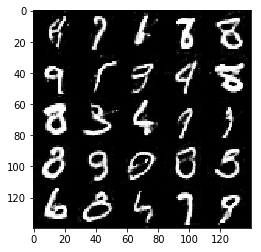

Epoch 8/10... Discriminator Loss: 1.2465... Generator Loss: 0.8216
Epoch 8/10... Discriminator Loss: 1.1787... Generator Loss: 0.9602
Epoch 8/10... Discriminator Loss: 1.1610... Generator Loss: 0.8867
Epoch 8/10... Discriminator Loss: 1.1298... Generator Loss: 0.8345
Epoch 8/10... Discriminator Loss: 1.2182... Generator Loss: 0.7741
Epoch 8/10... Discriminator Loss: 1.2992... Generator Loss: 0.6237
Epoch 8/10... Discriminator Loss: 1.2516... Generator Loss: 0.7825
Epoch 8/10... Discriminator Loss: 1.1620... Generator Loss: 0.8243
Epoch 8/10... Discriminator Loss: 1.1488... Generator Loss: 0.8547
Epoch 8/10... Discriminator Loss: 1.1837... Generator Loss: 0.8105


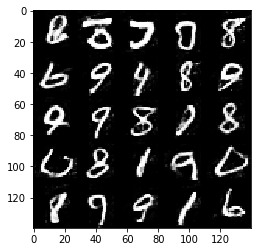

Epoch 8/10... Discriminator Loss: 1.2785... Generator Loss: 1.0243
Epoch 8/10... Discriminator Loss: 1.3601... Generator Loss: 0.4938
Epoch 8/10... Discriminator Loss: 1.7116... Generator Loss: 0.8712
Epoch 8/10... Discriminator Loss: 1.6334... Generator Loss: 1.4963
Epoch 8/10... Discriminator Loss: 1.2277... Generator Loss: 0.7539
Epoch 8/10... Discriminator Loss: 1.1827... Generator Loss: 0.9096
Epoch 8/10... Discriminator Loss: 1.1559... Generator Loss: 0.7712
Epoch 8/10... Discriminator Loss: 1.1183... Generator Loss: 0.8435
Epoch 8/10... Discriminator Loss: 1.1704... Generator Loss: 0.8516
Epoch 8/10... Discriminator Loss: 1.1549... Generator Loss: 0.7935


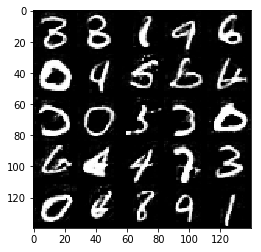

Epoch 8/10... Discriminator Loss: 1.1203... Generator Loss: 0.9040
Epoch 8/10... Discriminator Loss: 1.1333... Generator Loss: 1.2221
Epoch 8/10... Discriminator Loss: 1.1797... Generator Loss: 0.7018
Epoch 8/10... Discriminator Loss: 1.2057... Generator Loss: 0.6979
Epoch 8/10... Discriminator Loss: 1.2033... Generator Loss: 0.7615
Epoch 8/10... Discriminator Loss: 1.1766... Generator Loss: 0.9030
Epoch 8/10... Discriminator Loss: 1.1732... Generator Loss: 0.8935
Epoch 8/10... Discriminator Loss: 1.1115... Generator Loss: 0.9365
Epoch 8/10... Discriminator Loss: 1.1260... Generator Loss: 0.9305
Epoch 8/10... Discriminator Loss: 1.1587... Generator Loss: 0.8210


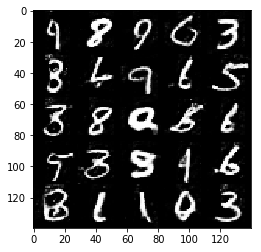

Epoch 8/10... Discriminator Loss: 1.0940... Generator Loss: 1.0941
Epoch 8/10... Discriminator Loss: 1.1618... Generator Loss: 0.9594
Epoch 8/10... Discriminator Loss: 1.2052... Generator Loss: 1.2345
Epoch 8/10... Discriminator Loss: 1.1874... Generator Loss: 0.9639
Epoch 8/10... Discriminator Loss: 1.1003... Generator Loss: 0.9932
Epoch 8/10... Discriminator Loss: 1.1836... Generator Loss: 0.7926
Epoch 8/10... Discriminator Loss: 1.1750... Generator Loss: 0.9737
Epoch 8/10... Discriminator Loss: 1.1773... Generator Loss: 0.8200
Epoch 8/10... Discriminator Loss: 1.1399... Generator Loss: 0.8360
Epoch 8/10... Discriminator Loss: 1.1566... Generator Loss: 0.8328


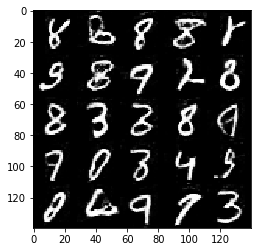

Epoch 8/10... Discriminator Loss: 1.2053... Generator Loss: 0.6851
Epoch 8/10... Discriminator Loss: 1.1300... Generator Loss: 0.8675
Epoch 8/10... Discriminator Loss: 1.1702... Generator Loss: 0.7814
Epoch 8/10... Discriminator Loss: 1.1556... Generator Loss: 0.9196
Epoch 9/10... Discriminator Loss: 1.1613... Generator Loss: 0.8612
Epoch 9/10... Discriminator Loss: 1.1853... Generator Loss: 0.9027
Epoch 9/10... Discriminator Loss: 1.1883... Generator Loss: 0.8227
Epoch 9/10... Discriminator Loss: 1.5307... Generator Loss: 0.6814
Epoch 9/10... Discriminator Loss: 1.9177... Generator Loss: 0.8250
Epoch 9/10... Discriminator Loss: 1.4279... Generator Loss: 0.9161


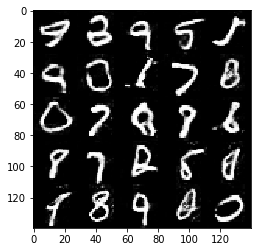

Epoch 9/10... Discriminator Loss: 1.1537... Generator Loss: 0.9748
Epoch 9/10... Discriminator Loss: 1.1420... Generator Loss: 0.9828
Epoch 9/10... Discriminator Loss: 1.1531... Generator Loss: 0.8567
Epoch 9/10... Discriminator Loss: 1.1353... Generator Loss: 0.8854
Epoch 9/10... Discriminator Loss: 1.1591... Generator Loss: 0.8316
Epoch 9/10... Discriminator Loss: 1.1811... Generator Loss: 0.8458
Epoch 9/10... Discriminator Loss: 1.2494... Generator Loss: 0.6075
Epoch 9/10... Discriminator Loss: 1.1180... Generator Loss: 0.7821
Epoch 9/10... Discriminator Loss: 1.1814... Generator Loss: 0.8632
Epoch 9/10... Discriminator Loss: 1.0807... Generator Loss: 0.7565


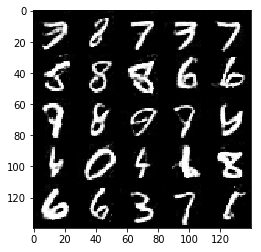

Epoch 9/10... Discriminator Loss: 1.1508... Generator Loss: 0.8673
Epoch 9/10... Discriminator Loss: 1.0662... Generator Loss: 0.9556
Epoch 9/10... Discriminator Loss: 1.1153... Generator Loss: 0.9733
Epoch 9/10... Discriminator Loss: 1.1692... Generator Loss: 0.9617
Epoch 9/10... Discriminator Loss: 1.2076... Generator Loss: 1.3376
Epoch 9/10... Discriminator Loss: 1.1049... Generator Loss: 0.8824
Epoch 9/10... Discriminator Loss: 1.1624... Generator Loss: 0.7014
Epoch 9/10... Discriminator Loss: 1.0893... Generator Loss: 0.9403
Epoch 9/10... Discriminator Loss: 1.1170... Generator Loss: 0.8640
Epoch 9/10... Discriminator Loss: 1.1211... Generator Loss: 0.7167


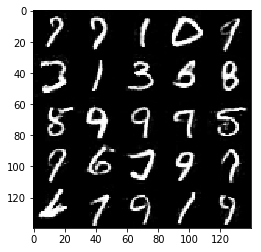

Epoch 9/10... Discriminator Loss: 1.0874... Generator Loss: 0.9647
Epoch 9/10... Discriminator Loss: 1.0879... Generator Loss: 0.7739
Epoch 9/10... Discriminator Loss: 1.1172... Generator Loss: 0.8415
Epoch 9/10... Discriminator Loss: 1.1125... Generator Loss: 0.8044
Epoch 9/10... Discriminator Loss: 1.1197... Generator Loss: 0.8985
Epoch 9/10... Discriminator Loss: 1.2168... Generator Loss: 1.0424
Epoch 9/10... Discriminator Loss: 1.0957... Generator Loss: 0.7929
Epoch 9/10... Discriminator Loss: 1.0793... Generator Loss: 0.9767
Epoch 9/10... Discriminator Loss: 1.1072... Generator Loss: 1.0745
Epoch 9/10... Discriminator Loss: 1.3441... Generator Loss: 1.3771


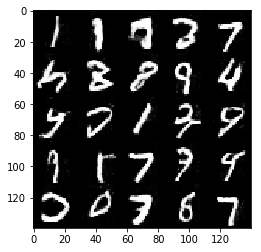

Epoch 9/10... Discriminator Loss: 1.0107... Generator Loss: 1.0735
Epoch 9/10... Discriminator Loss: 1.1550... Generator Loss: 0.7931
Epoch 9/10... Discriminator Loss: 1.1053... Generator Loss: 0.8188
Epoch 9/10... Discriminator Loss: 1.0822... Generator Loss: 0.8894
Epoch 9/10... Discriminator Loss: 1.1857... Generator Loss: 0.7347
Epoch 9/10... Discriminator Loss: 1.0096... Generator Loss: 0.9987
Epoch 9/10... Discriminator Loss: 1.1472... Generator Loss: 0.8063
Epoch 9/10... Discriminator Loss: 1.1214... Generator Loss: 1.0191
Epoch 9/10... Discriminator Loss: 1.1187... Generator Loss: 0.9675
Epoch 9/10... Discriminator Loss: 1.0877... Generator Loss: 0.9293


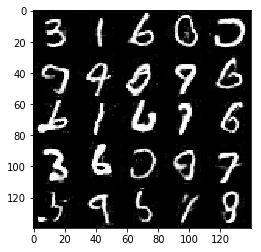

Epoch 9/10... Discriminator Loss: 1.1070... Generator Loss: 0.7095
Epoch 10/10... Discriminator Loss: 1.0649... Generator Loss: 0.8886
Epoch 10/10... Discriminator Loss: 1.1610... Generator Loss: 0.9611
Epoch 10/10... Discriminator Loss: 1.4066... Generator Loss: 0.7724
Epoch 10/10... Discriminator Loss: 1.0957... Generator Loss: 1.1341
Epoch 10/10... Discriminator Loss: 1.0812... Generator Loss: 1.0641
Epoch 10/10... Discriminator Loss: 1.0914... Generator Loss: 0.9151
Epoch 10/10... Discriminator Loss: 1.0679... Generator Loss: 1.0547
Epoch 10/10... Discriminator Loss: 1.1559... Generator Loss: 1.1066
Epoch 10/10... Discriminator Loss: 1.0884... Generator Loss: 0.9359


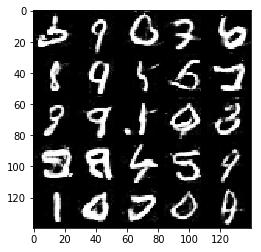

Epoch 10/10... Discriminator Loss: 1.1530... Generator Loss: 0.9135
Epoch 10/10... Discriminator Loss: 1.1078... Generator Loss: 1.1415
Epoch 10/10... Discriminator Loss: 1.1753... Generator Loss: 0.6724
Epoch 10/10... Discriminator Loss: 1.1138... Generator Loss: 0.7215
Epoch 10/10... Discriminator Loss: 1.0256... Generator Loss: 1.1917
Epoch 10/10... Discriminator Loss: 1.1354... Generator Loss: 0.9624
Epoch 10/10... Discriminator Loss: 1.1368... Generator Loss: 0.8475
Epoch 10/10... Discriminator Loss: 1.0828... Generator Loss: 0.9074
Epoch 10/10... Discriminator Loss: 1.1278... Generator Loss: 1.1136
Epoch 10/10... Discriminator Loss: 1.3403... Generator Loss: 1.5471


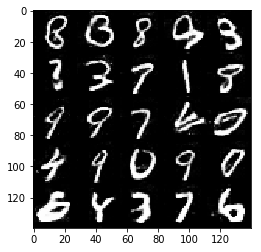

Epoch 10/10... Discriminator Loss: 1.0855... Generator Loss: 0.8648
Epoch 10/10... Discriminator Loss: 2.9008... Generator Loss: 1.5476
Epoch 10/10... Discriminator Loss: 1.8473... Generator Loss: 1.5146
Epoch 10/10... Discriminator Loss: 1.3336... Generator Loss: 0.8293
Epoch 10/10... Discriminator Loss: 1.1401... Generator Loss: 0.9052
Epoch 10/10... Discriminator Loss: 1.0684... Generator Loss: 0.8901
Epoch 10/10... Discriminator Loss: 1.0707... Generator Loss: 0.9128
Epoch 10/10... Discriminator Loss: 1.0550... Generator Loss: 0.8997
Epoch 10/10... Discriminator Loss: 1.0411... Generator Loss: 0.8872
Epoch 10/10... Discriminator Loss: 1.0708... Generator Loss: 0.9746


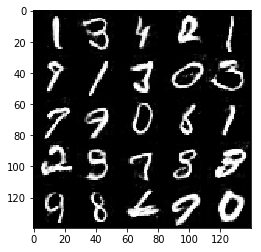

Epoch 10/10... Discriminator Loss: 1.0765... Generator Loss: 0.9670
Epoch 10/10... Discriminator Loss: 1.0150... Generator Loss: 0.9403
Epoch 10/10... Discriminator Loss: 1.0793... Generator Loss: 0.7430
Epoch 10/10... Discriminator Loss: 1.0679... Generator Loss: 0.8935
Epoch 10/10... Discriminator Loss: 1.0487... Generator Loss: 1.1433
Epoch 10/10... Discriminator Loss: 1.0590... Generator Loss: 0.9534
Epoch 10/10... Discriminator Loss: 1.0854... Generator Loss: 1.1031
Epoch 10/10... Discriminator Loss: 1.0391... Generator Loss: 0.9984
Epoch 10/10... Discriminator Loss: 1.0978... Generator Loss: 0.7768
Epoch 10/10... Discriminator Loss: 1.0392... Generator Loss: 0.9731


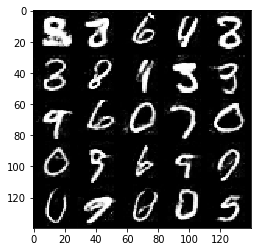

Epoch 10/10... Discriminator Loss: 0.9991... Generator Loss: 1.0917
Epoch 10/10... Discriminator Loss: 1.0430... Generator Loss: 0.9032
Epoch 10/10... Discriminator Loss: 1.1172... Generator Loss: 0.6520
Epoch 10/10... Discriminator Loss: 1.0501... Generator Loss: 0.8683
Epoch 10/10... Discriminator Loss: 1.0679... Generator Loss: 0.7272
Epoch 10/10... Discriminator Loss: 1.1004... Generator Loss: 0.6553
Epoch 10/10... Discriminator Loss: 1.0704... Generator Loss: 0.9646
Epoch 10/10... Discriminator Loss: 1.0808... Generator Loss: 1.1316


In [12]:
#batch_size = None
#z_dim = None
#learning_rate = None
#beta1 = None


batch_size = 128
z_dim = 150
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1004... Generator Loss: 1.5114
Epoch 1/1... Discriminator Loss: 0.5158... Generator Loss: 1.8604
Epoch 1/1... Discriminator Loss: 2.1006... Generator Loss: 1.2175
Epoch 1/1... Discriminator Loss: 0.7213... Generator Loss: 1.0667
Epoch 1/1... Discriminator Loss: 0.7112... Generator Loss: 1.7622
Epoch 1/1... Discriminator Loss: 0.9828... Generator Loss: 2.1006
Epoch 1/1... Discriminator Loss: 0.8302... Generator Loss: 1.2298
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.5223
Epoch 1/1... Discriminator Loss: 1.5802... Generator Loss: 1.0906
Epoch 1/1... Discriminator Loss: 0.9291... Generator Loss: 0.8963


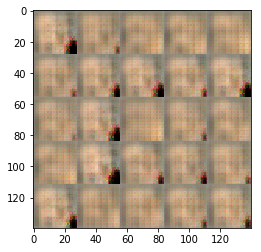

Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 1.0860
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 0.9501... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 3.7327... Generator Loss: 1.5738
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 0.9800
Epoch 1/1... Discriminator Loss: 0.9759... Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 0.9924
Epoch 1/1... Discriminator Loss: 1.0343... Generator Loss: 0.9358


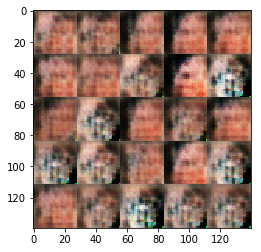

Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 0.9137
Epoch 1/1... Discriminator Loss: 3.1538... Generator Loss: 1.1930
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.0303... Generator Loss: 0.9997
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 0.9971
Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 1.0304... Generator Loss: 1.0142
Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 0.8787


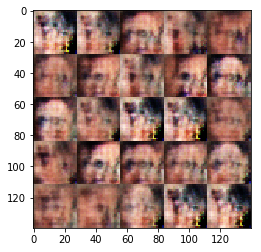

Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.9916
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.9445
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 1.0506
Epoch 1/1... Discriminator Loss: 5.3024... Generator Loss: 1.6353
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 0.8493


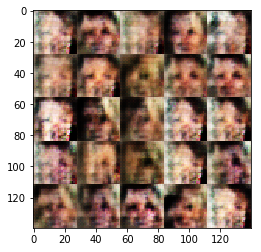

Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.1108... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 1.0429
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.9084
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.9325
Epoch 1/1... Discriminator Loss: 2.0779... Generator Loss: 0.9763


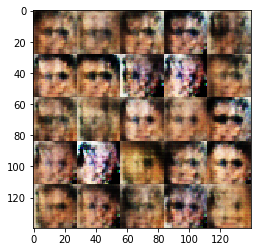

Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.7733


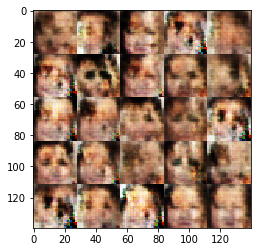

Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.8494
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.8025


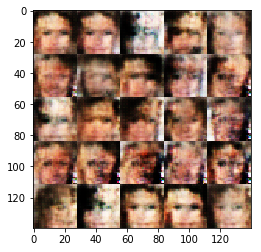

Epoch 1/1... Discriminator Loss: 2.1400... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 0.8059


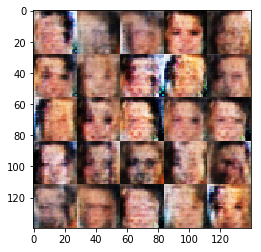

Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 5.1138... Generator Loss: 1.5560
Epoch 1/1... Discriminator Loss: 1.2057... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 0.7726


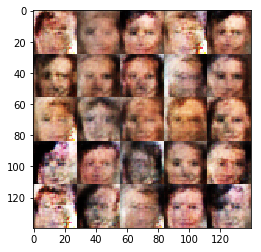

Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.5099... Generator Loss: 1.1083
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.5250... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7204


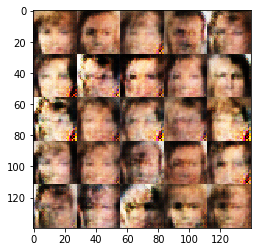

Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.7263


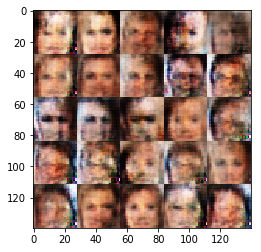

Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.7496


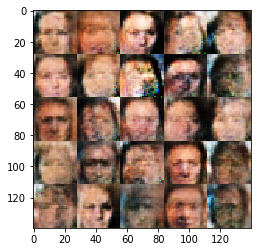

Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.7475


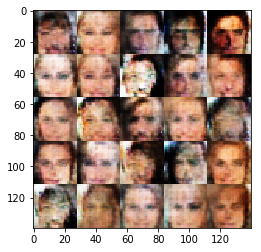

Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 2.0342... Generator Loss: 0.9752
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.7952


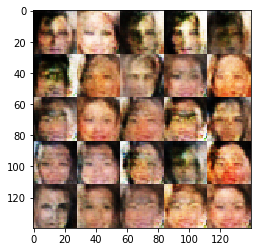

Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.7631


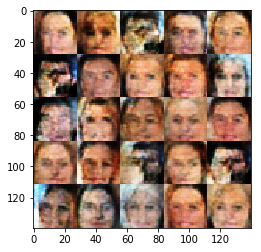

Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.8658
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7577


In [ ]:
# batch_size = None
# z_dim = None
# learning_rate = None
# beta1 = None


batch_size = 128
z_dim = 150
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.